In [1]:
import sys
sys.path.append('C:/Users/PCMC/notebooks/Masters/PDF to Text/Next_gen/Text_Extract')
from text_extract_V2 import PDF_to_Para
import pandas as pd
from datasets import load_dataset
from transformers import (
    RobertaTokenizerFast,
    RobertaForSequenceClassification,
)
import pandas as pd
from sklearn.metrics import cohen_kappa_score
from transformers import pipeline
%matplotlib inline

In [2]:
# extract text from pdf
company_name="EON"
year=2021
df=PDF_to_Para(company_name,year,"reports\EON_2021_Sustainability_Report.pdf")
df=df[["text","Company","year"]]

In [4]:
# load fine-tuned model for level-2 classification
model_directory="fine_tuning\\roberta_final_top_no_zero_save"
model = RobertaForSequenceClassification.from_pretrained(model_directory)
tokenizer= RobertaTokenizerFast.from_pretrained(model_directory, truncation=True)
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)
tokenizer_kwargs = {'truncation':True,'max_length':512,}

A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


In [5]:
# fuction to get model labels
def get_labels(df):
    res=classifier(df.text.to_list(),**tokenizer_kwargs)
    df["model_label"]=[res[i]["label"] for i in range(0,len(df))]
    df["score"]=[res[i]["score"] for i in range(0,len(df))]
    df=df.replace({"model_label":{0: "E1", 1: "E2", 2: "E3", 3:"E4", 4 : "E5", 5: "S1", 6:"S2",7: "S3", 8: "S4", 9:"G1"}})
    return df

In [6]:
df=get_labels(df)# get labels

<Axes: >

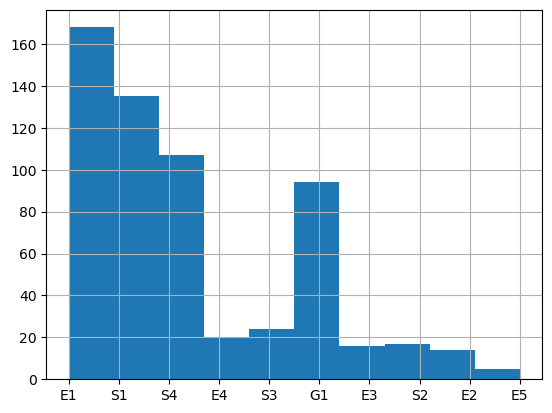

In [7]:
df.model_label.hist()

In [8]:
E1_df=df[(df["model_label"]=="E1")].reset_index(drop=True)# select all E1 paragraphs

In [9]:
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, pipeline
import torch

In [10]:
#load question answering model
question_model = "deepset/roberta-base-squad2"
model = AutoModelForQuestionAnswering.from_pretrained(question_model)
tokenizer = AutoTokenizer.from_pretrained(question_model)
nlp = pipeline('question-answering', model=question_model, tokenizer=question_model)

In [11]:
# function returns paragraph with higest score and the corresponding score
def get_answers(question,df):
    answer=[]
    for i in range(0,len(df)):
        QA_input={"question":question, 'context':df.at[i,"text"] } # ask the question with each entry in the dataframe as context
        res = nlp(QA_input)
        answer.append([df.at[i,"text"],res["score"]]) # list of context paragraphs and corsponding scores
    answer.sort(key=lambda x: x[1],reverse=True) # sort list by score, highest to lowest
    return answer[0] # return top entry

In [13]:
# define questions, format "sublabel", "question"
sublabel_questions=[
    ["E1-1","What is {} Transition plan for climate change mitigation".format(company_name)],
    ["E1-2","What policies were adopted by{}".format(company_name)],
    ["E1-3","What did {} do to mitigate climate change".format(company_name)],
    ["E1-3","How much resources did {} invest to mitigate climate change".format(company_name)],
    ["E1-4","What are {}'s GHG emission reduction targets".format(company_name)],
    ["E1-5","How much fuel consumption from coal"],
    ["E1-5","How much fuel consumption from natural gas"],
    ["E1-5","How much fuel consumption from nuclear"],
    ["E1-5","How much fuel consumption from renewable sources"],
    ["E1-6","How much gross Scope 1 GHG emissions."],
    ["E1-6","How much gross Scope 2 GHG emissions."],
    ["E1-6","How much gross Scope 3 GHG emissions."],
    ["E1-7","How much GHG removed."],
    ["E1-7","How much GHG mitigated due to carbon credits."],
    ["E1-8","What is {}'s internal carbon pricing".format(company_name)],
    ["E1-9","What are financial risks associated with climate change"],
    ["E1-9","What are financial opportunities associated with climate change"]
    
]

In [25]:
# run get_answers on all the questions above
answers_list=[]
for i in range(0,len(sublabel_questions)):
    answer=get_answers(sublabel_questions[i][1],E1_df)
    answers_list.append([sublabel_questions[i][0],sublabel_questions[i][1],answer[0],answer[1]]) # collect "sublabel","question","best context","score"

In [26]:
answers_df=pd.DataFrame(answers_list, columns=["sublabel","question","answer","score"])# convert to df

In [28]:
answers_df.to_csv("E.ON_E1_sublabels.csv")# write to csv